In [1]:
import skimage.io
import skimage.filters
import sys
import cv2
import numpy as np
from PIL import Image
import PIL
from skimage import io
import os
from os import listdir
from os.path import isfile, join
from predict_util import *
import urllib.request
import ssl
import pickle
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import pandas as pd

/Users/metis_sotangkur/opt/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [3]:
gblur_level = np.linspace(9, 200, num=10)
def generate_blur_img(level, image, image_num):
    hsize = gblur_level[level]
#         distorted_img = cv2.GaussianBlur(image,(hsize,hsize),cv2.BORDER_DEFAULT)
    hsize = int(hsize)
    if hsize % 2 == 0:
        hsize += 1
#     print(hsize)
    distorted_img = cv2.GaussianBlur(image,(hsize,hsize),cv2.BORDER_DEFAULT)
    im = PIL.Image.fromarray(distorted_img)
    if image_num < 10:
        image_num = f'0{image_num}'
    else:
        image_num = f'{image_num}'
    if level < 10:
        level = f'0{level}'
    else:
        level = f'{level}'
    
    tmp_path = f'/Users/metis_sotangkur/Desktop/Senior/Capstone/distorted_img/{image_num}_{level}.jpg'
    im.save(tmp_path,"JPEG")

def generate_motion_blur(level, image, image_num):
    kernel_size = int(np.linspace(9, 100, num=10)[level*2])
#     print(kernel_size)
#     print(kernel_size)
    kernel_v = np.zeros((kernel_size, kernel_size))
    kernel_h = np.copy(kernel_v)
    kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    kernel_v /= kernel_size
    kernel_h /= kernel_size
    vertical_mb = cv2.filter2D(image, -1, kernel_v)
    horizonal_mb = cv2.filter2D(image, -1, kernel_h)
#     if level == 0:
#         kernel[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
#     kernel /= kernel_size
#     distorted_img = cv2.filter2D(image, -1, kernel)
    im = PIL.Image.fromarray(horizonal_mb)
    if image_num < 10:
        image_num = f'0{image_num}'
    else:
        image_num = f'{image_num}'
    if level < 10:
        level = f'0{level}'
    else:
        level = f'{level}'
    
    save_pth = '/Users/metis_sotangkur/Desktop/Senior/Capstone/threshold_testing_img/'
    tmp_path = os.path.join(save_pth, f'{image_num}_{level}.jpg')
#     if int(level) < 2:
#         tmp_path = os.path.join(save_pth, 'class_1', f'{image_num}_{level}.jpg')
    
#     else:
#         tmp_path = os.path.join(save_pth, 'class_0', f'{image_num}_{level}.jpg')
    im.save(tmp_path,"JPEG")

mypath = '/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001'
onlyfiles = [os.path.join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]

for idx, path in enumerate(onlyfiles):
    if not path.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        continue
    print(path)
    image = io.imread(path, plugin='matplotlib')
    for level in range(4):
        generate_motion_blur(level, image, idx+100)
        

/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000151.jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000145.jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000144.jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000150.jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000278(1).jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000077(1).jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000169(1).jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000165(1).jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000146.jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000152.jpg
/Users/metis_sotangkur/Downloads/drive-download-20220216T071007Z-001/ISIC_0000153.jpg
/Users/metis_sotangkur/Downloads/drive-dow

In [7]:
from predict_util import *
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
response = urllib.request.urlopen('https://www.python.org')
# print(response.read().decode('utf-8'))
S_CNN_PATH = 'revised_model_13_10_2021_0.pth'
MODEL_PATH = 'db_cnn_v2_challenge.pth'
# EXAMPLE_IMG_PATH = '/Users/metis_sotangkur/Desktop/Senior/Capstone/distorted_img2/00_00.jpg'
Predict = PREDICT_UTIL(model_path=MODEL_PATH, s_cnn_path=S_CNN_PATH)
Predict.load_model()


thresholding_path = '../distorted_img2'
img_files = sorted([os.path.join(thresholding_path, f) for f in os.listdir(thresholding_path) \
                 if os.path.isfile(os.path.join(thresholding_path, f)) \
                 and f.lower().endswith(('.png', '.jpg', '.jpeg'))])
score_dict = {}
for pth in img_files:
    img_name = pth.split('/')[-1]
    print(img_name)
    img = Image.open(pth).convert('RGB')
    score = Predict.predict_img_2(img)
    score_dict[img_name] = score
with open('scores.pkl', 'wb') as f:
    pickle.dump(score_dict, f)

00_00.jpg


/Users/metis_sotangkur/Desktop/Senior/Capstone/compact_bilinear_pooling_cnn/compact_bilinear_pooling.py:116: UserWarning: This overload of addcmul is deprecated:
	addcmul(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcmul(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  Z_re = torch.addcmul(X_re*Y_re, -1, X_im, Y_im)


00_01.jpg
00_02.jpg
00_03.jpg
00_04.jpg
00_05.jpg
00_06.jpg
00_07.jpg
00_08.jpg
00_09.jpg
01_00.jpg
01_01.jpg
01_02.jpg
01_03.jpg
01_04.jpg
01_05.jpg
01_06.jpg
01_07.jpg
01_08.jpg
01_09.jpg
02_00.jpg
02_01.jpg
02_02.jpg
02_03.jpg
02_04.jpg
02_05.jpg
02_06.jpg
02_07.jpg
02_08.jpg
02_09.jpg
03_00.jpg
03_01.jpg
03_02.jpg
03_03.jpg
03_04.jpg
03_05.jpg
03_06.jpg
03_07.jpg
03_08.jpg
03_09.jpg
04_00.jpg
04_01.jpg
04_02.jpg
04_03.jpg
04_04.jpg
04_05.jpg
04_06.jpg
04_07.jpg
04_08.jpg
04_09.jpg
05_00.jpg
05_01.jpg
05_02.jpg
05_03.jpg
05_04.jpg
05_05.jpg
05_06.jpg
05_07.jpg
05_08.jpg
05_09.jpg
06_00.jpg
06_01.jpg
06_02.jpg
06_03.jpg
06_04.jpg
06_05.jpg
06_06.jpg
06_07.jpg
06_08.jpg
06_09.jpg
07_00.jpg
07_01.jpg
07_02.jpg
07_03.jpg
07_04.jpg
07_05.jpg
07_06.jpg
07_07.jpg
07_08.jpg
07_09.jpg
08_00.jpg
08_01.jpg
08_02.jpg
08_03.jpg
08_04.jpg
08_05.jpg
08_06.jpg
08_07.jpg
08_08.jpg
08_09.jpg
09_00.jpg
09_01.jpg
09_02.jpg
09_03.jpg
09_04.jpg
09_05.jpg
09_06.jpg
09_07.jpg
09_08.jpg
09_09.jpg
100_00.jpg

In [5]:
import pandas as pd
dr_tung = pd.read_excel('../dermatologist_decision/image_list.xlsx')[['file_name', 'can diagnose']].fillna(0)
dr_tung = dr_tung.rename(columns={"can diagnose": "dr_tung"})
dr_joy = pd.read_excel('../dermatologist_decision/image_BYJOY.xls')[['file_name', 'can diagnose']].fillna(0)
dr_joy = dr_joy.rename(columns={"can diagnose": "dr_joy"})
dr_3 = pd.read_excel('../dermatologist_decision/image_list_3.xlsx')[['file_name', 'can diagnose']].fillna(0)
dr_3 = dr_3.rename(columns={'can diagnose': 'dr_3'})
df = dr_tung.merge(dr_joy, on=['file_name'], how='inner')
df = df.merge(dr_3, on=['file_name'], how='inner')
df['dr_joy'] = df['dr_joy'].astype(int)
# dr_joy['can diagnose'] = dr_joy['can diagnose'].astype(float)
# two_doctor = dr_tung.merge(dr_joy, on=['file_name'], how='inner', suffixes=('_dr_tung', '_dr_joy'))
# two_doctor['diff'] = two_doctor['can diagnose_dr_tung'] == two_doctor['can diagnose_dr_joy']
with open('scores.pkl', 'rb') as f:
    score_dict = pickle.load(f)

In [9]:
# two_doctor['diff'].value_counts()

True     289
False     50
Name: diff, dtype: int64

In [32]:
file_name = []
predict_score = []
for k, v in score_dict.items():
    file_name.append(k)
    predict_score.append(v)
data_predict = {'file_name': file_name, 'predict_score': predict_score}
predict = pd.DataFrame(data_predict)
def get_threshold(dermatologist_df, col_name='can diagnose'):
    print(f'Now processing the threshold from {col_name}')
    all_data = dermatologist_df.merge(predict, how='left', on='file_name').dropna()
    X, y = all_data['predict_score'].to_numpy(), all_data[col_name].to_numpy()
    y = 1 - y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2022, stratify=y)
    print(len(y_test))
    print(f'Label 1 count: {y_test.tolist().count(1)}')
    print(f'Label 0 count: {y_test.tolist().count(0)}')
    kf = KFold(n_splits=3)
    threholds = []
    for train, test in kf.split(X_train):
        X_train_kf, y_train_kf = X_train[train], y_train[train]
        X_test_kf, y_test_kf = X_train[test], y_train[test]
        fpr, tpr, thresholds = metrics.roc_curve(y_train_kf, X_train_kf)
        auc = metrics.auc(fpr, tpr)
        EER = [t for fp, tp, t in zip(fpr, tpr, thresholds) if abs(fp+tp-1)<=3e-2][0]
        threholds.append(EER)
        print(f'Theshold at EER: {EER}')
        print(f'auc: {auc}')

        X_test_kf = (X_test_kf >= EER) + 0
        acc = sum(X_test_kf == y_test_kf)/(len(X_test_kf))
        tp = sum((X_test_kf == 1) & (y_test_kf == 1))
        tn = sum((X_test_kf == 0) & (y_test_kf == 0))
        fp = sum((X_test_kf == 1) & (y_test_kf == 0))
        fn = sum((X_test_kf == 0) & (y_test_kf == 1))
        print(f'accuracy on test: {acc}')
        print(f'Precision on test: {tp/(tp+fp)}')
        print(f'Recall on test: {tp/(tp+fn)}')
        print()
        plt.title('ROC')
        plt.plot(fpr, tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Alarm Rate')
        plt.show()
        
    threholds = sorted(threholds)
    thres = round(threholds[1], 4)
    print(f'using threhold at {thres} for test dataset')
    X_test = (X_test >= thres) + 0
    acc = sum(X_test == y_test)/(len(X_test))
    tp = sum((X_test == 1) & (y_test == 1))
    tn = sum((X_test == 0) & (y_test == 0))
    fp = sum((X_test == 1) & (y_test == 0))
    fn = sum((X_test == 0) & (y_test == 1))
    print(f'accuracy on test: {acc}')
    print(f'Precision on test: {tp/(tp+fp)}')
    print(f'Recall on test: {tp/(tp+fn)}')
    print()

Now processing the threshold from dr_tung
67
Label 1 count: 14
Label 0 count: 53
Theshold at EER: 20.620925903320312
auc: 0.8728991596638656
accuracy on test: 0.6777777777777778
Precision on test: 0.3076923076923077
Recall on test: 0.8571428571428571



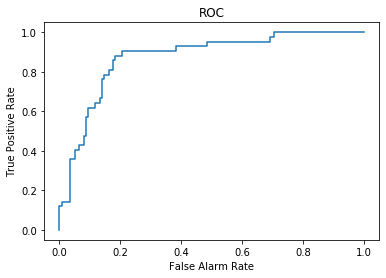

Theshold at EER: 20.8992977142334
auc: 0.860730593607306
accuracy on test: 0.8426966292134831
Precision on test: 0.6551724137931034
Recall on test: 0.8260869565217391



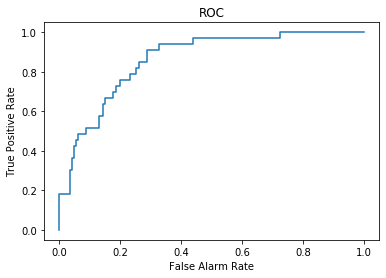

Theshold at EER: 21.59793472290039
auc: 0.8641035401598782
accuracy on test: 0.8314606741573034
Precision on test: 0.5909090909090909
Recall on test: 0.6842105263157895



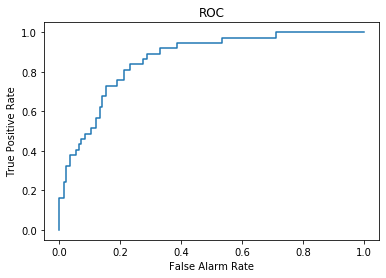

using threhold at 20.8993 for test dataset
accuracy on test: 0.7761194029850746
Precision on test: 0.47619047619047616
Recall on test: 0.7142857142857143



In [33]:
dr_tung_col = 'dr_tung'
get_threshold(df[['file_name', dr_tung_col]], col_name=dr_tung_col)

Now processing the threshold from dr_joy
67
Label 1 count: 24
Label 0 count: 43
Theshold at EER: 18.51202964782715
auc: 0.8280573593073592
accuracy on test: 0.6555555555555556
Precision on test: 0.4878048780487805
Recall on test: 0.6666666666666666



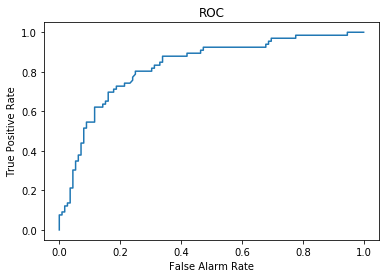

Theshold at EER: 18.460670471191406
auc: 0.786302294197031
accuracy on test: 0.7640449438202247
Precision on test: 0.631578947368421
Recall on test: 0.7741935483870968



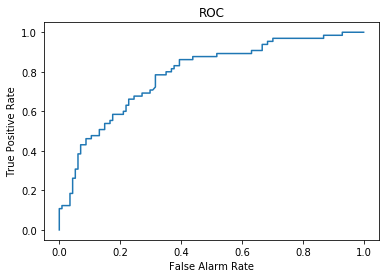

Theshold at EER: 19.065570831298828
auc: 0.8011253125868296
accuracy on test: 0.7640449438202247
Precision on test: 0.7058823529411765
Recall on test: 0.6857142857142857



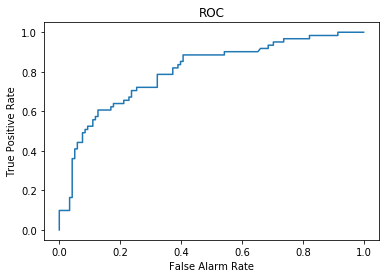

using threhold at 18.512 for test dataset
accuracy on test: 0.7611940298507462
Precision on test: 0.6428571428571429
Recall on test: 0.75



In [34]:
dr_joy_col = 'dr_joy'
get_threshold(df[['file_name', dr_joy_col]], col_name=dr_joy_col)

Now processing the threshold from dr_3
67
Label 1 count: 17
Label 0 count: 50
Theshold at EER: 19.188762664794922
auc: 0.8232371794871794
accuracy on test: 0.7888888888888889
Precision on test: 0.5151515151515151
Recall on test: 0.85



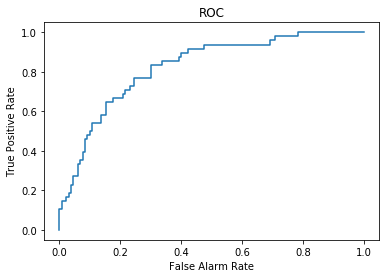

Theshold at EER: 20.57086181640625
auc: 0.8764510779436152
accuracy on test: 0.7191011235955056
Precision on test: 0.4666666666666667
Recall on test: 0.6086956521739131



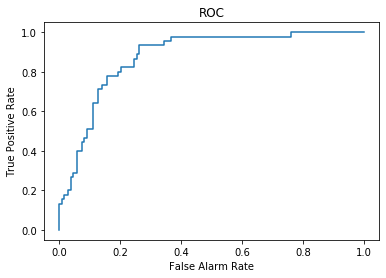

Theshold at EER: 19.188762664794922
auc: 0.820280437756498
accuracy on test: 0.797752808988764
Precision on test: 0.6060606060606061
Recall on test: 0.8



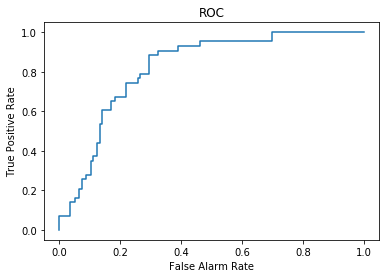

using threhold at 19.1888 for test dataset
accuracy on test: 0.7910447761194029
Precision on test: 0.5517241379310345
Recall on test: 0.9411764705882353



In [35]:
dr_3_col = 'dr_3'
get_threshold(df[['file_name', dr_3_col]], col_name=dr_3_col)

In [12]:

# kf = KFold(n_splits=3)

# for train, test in kf.split(X_train):
#     X_train_kf, y_train_kf = X_train[train], y_train[train]
#     X_test_kf, y_test_kf = X_train[test], y_train[test]
#     fpr, tpr, thresholds = metrics.roc_curve(y_train_kf, X_train_kf)
#     auc = metrics.auc(fpr, tpr)
#     EER = [t for fp, tp, t in zip(fpr, tpr, thresholds) if abs(fp+tp-1)<=3e-2][0]
    
#     print(f'Theshold at EER: {EER}')
#     print(f'auc: {auc}')
    
#     X_test_kf = (X_test_kf >= EER) + 0
#     acc = sum(X_test_kf == y_test_kf)/(len(X_test_kf))
#     tp = sum((X_test_kf == 1) & (y_test_kf == 1))
#     tn = sum((X_test_kf == 0) & (y_test_kf == 0))
#     fp = sum((X_test_kf == 1) & (y_test_kf == 0))
#     fn = sum((X_test_kf == 0) & (y_test_kf == 1))
#     print(f'accuracy on test: {acc}')
#     print(f'Precision on test: {tp/(tp+fp)}')
#     print(f'Recall on test: {tp/(tp+fn)}')
#     print()
#     plt.title('ROC')
#     plt.plot(fpr, tpr)
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Alarm Rate')
#     plt.show()

In [13]:
# thres = 20.0937
# X_test = (X_test >= thres) + 0
# acc = sum(X_test == y_test)/(len(X_test))
# tp = sum((X_test == 1) & (y_test == 1))
# tn = sum((X_test == 0) & (y_test == 0))
# fp = sum((X_test == 1) & (y_test == 0))
# fn = sum((X_test == 0) & (y_test == 1))
# print(f'accuracy on test: {acc}')
# print(f'Precision on test: {tp/(tp+fp)}')
# print(f'Recall on test: {tp/(tp+fn)}')
# print()